In [44]:
%load_ext autoreload
%autoreload 2

import os
import re
import math
import glob
from importlib import reload

import tqdm 
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
obj_dataset = dataset.replay_mapping_from_cache(3000)

Loading objects from .data/: 100%|██████████| 3000/3000 [01:31<00:00, 32.66it/s]


In [46]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
2535,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2536,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2537,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2538,<osu.rulesets.replay.Replay object at 0x000001...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [47]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

Turning replays into time series data: 100%|██████████| 2540/2540 [01:32<00:00, 27.61it/s]


In [48]:
input = input_data
output = output_data

In [49]:
output[0:500]

x         y   k1   k2
chunk frame                              
0     0     -0.220486 -0.116898  0.0  0.0
      1     -0.220486 -0.116898  0.0  0.0
      2     -0.229167 -0.108796  0.0  0.0
      3     -0.229167 -0.108796  0.0  0.0
      4     -0.227430 -0.107639  0.0  0.0
...               ...       ...  ...  ...
      495    0.107639  0.005787  0.0  1.0
      496    0.165799  0.015046  0.0  1.0
      497    0.174479  0.024305  0.0  1.0
      498    0.187500  0.041667  0.0  1.0
      499    0.187500  0.040509  0.0  1.0

[500 rows x 4 columns]

In [50]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

(9628, 2048, 5)

In [51]:
xs

array([[[-0.35546875, -0.5       ,  0.45      ,  1.        ,
          0.        ],
        [-0.35546875, -0.5       ,  0.426     ,  1.        ,
          0.        ],
        [-0.35546875, -0.5       ,  0.402     ,  1.        ,
          0.        ],
        ...,
        [-0.41601562, -0.03125   ,  0.058     ,  1.        ,
          0.        ],
        [-0.41601562, -0.03125   ,  0.034     ,  1.        ,
          0.        ],
        [-0.41601562, -0.03125   ,  0.01      ,  1.        ,
          0.        ]],

       [[-0.42578125, -0.0546875 ,  0.        ,  1.        ,
          0.        ],
        [-0.4375    , -0.09375   ,  0.        ,  1.        ,
          0.        ],
        [-0.44140625, -0.13802083,  0.        ,  1.        ,
          0.        ],
        ...,
        [ 0.328125  ,  0.3828125 ,  0.087     ,  1.        ,
          0.        ],
        [ 0.328125  ,  0.3828125 ,  0.063     ,  1.        ,
          0.        ],
        [ 0.328125  ,  0.3828125 ,  0.039     , 

In [52]:
# ys = ys[0:xs.shape[0]]

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 
# x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))
# 
# train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
# 
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
from osu.rnn import OsuReplayRNN

In [67]:
print("Creating RNN model...")
rnn = OsuReplayRNN(batch_size=BATCH_SIZE, noise_std=0.00)
rnn.load_data(xs, ys)

Creating RNN model...
RNN Model initialized on cuda (noise_std=0.0)
Position model parameters: 226114
Data loaded: 7702 training samples, 1926 test samples (position only)


Epoch 1/10 (Train): 100%|██████████| 61/61 [00:13<00:00,  4.42it/s]


Epoch 1/10, Train: 0.0067, Test: 0.0023


Epoch 2/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.84it/s]


Epoch 2/10, Train: 0.0022, Test: 0.0019


Epoch 3/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.80it/s]


Epoch 3/10, Train: 0.0019, Test: 0.0018


Epoch 4/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.77it/s]


Epoch 4/10, Train: 0.0018, Test: 0.0016


Epoch 5/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.78it/s]


Epoch 5/10, Train: 0.0015, Test: 0.0014


Epoch 6/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.79it/s]


Epoch 6/10, Train: 0.0014, Test: 0.0013


Epoch 7/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.76it/s]


Epoch 7/10, Train: 0.0013, Test: 0.0013


Epoch 8/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.83it/s]


Epoch 8/10, Train: 0.0013, Test: 0.0013


Epoch 9/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.73it/s]


Epoch 9/10, Train: 0.0013, Test: 0.0012


Epoch 10/10 (Train): 100%|██████████| 61/61 [00:07<00:00,  7.78it/s]


Epoch 10/10, Train: 0.0013, Test: 0.0012


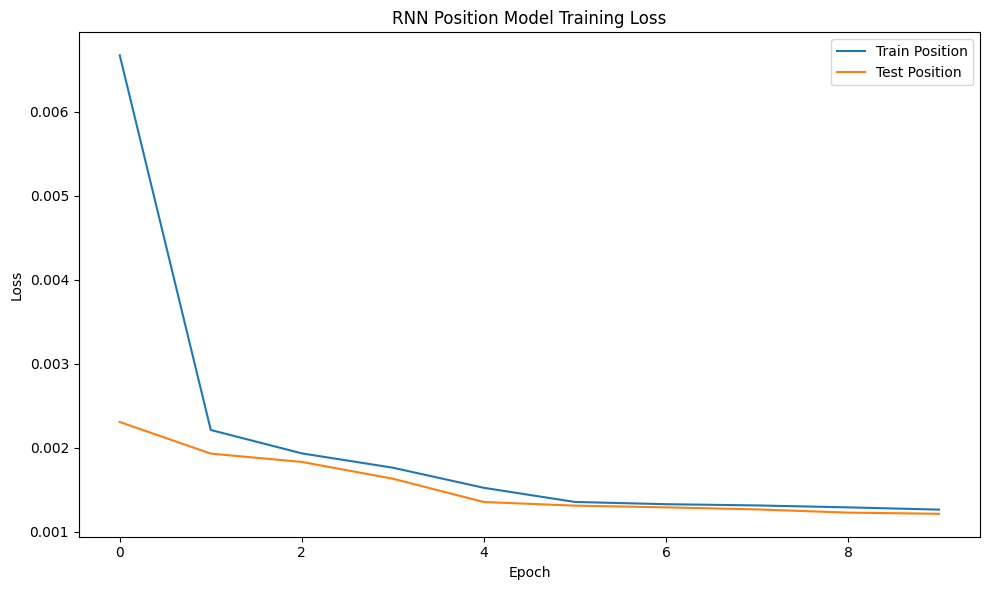

RNN model saved to .trained/rnn_2025-07-16_14-27-39.pt


In [70]:
RNN_EPOCHS = 10

# Train the RNN
rnn.train(epochs=RNN_EPOCHS)
rnn.plot_losses()
rnn.save()

In [104]:
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

1764

In [96]:
from osu.gan import OsuReplayGAN

In [97]:
print("Creating GAN model...")
gan = OsuReplayGAN(batch_size=BATCH_SIZE)
gan.load_data(xs, ys)

Creating GAN model...
GAN Models initialized on cuda
Generator parameters: 226114
Discriminator parameters: 54593
Data loaded: 7702 training samples, 1926 test samples (position only)


In [98]:
GAN_EPOCHS = 6

# Train the GAN
for i in range(8):
    gan.train(epochs=GAN_EPOCHS)
    gan.save()
    
gan.plot_losses()

Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:37<00:00,  3.57s/it]


Epoch 1/6, Gen: 0.7624 (Pos: 0.0070), Disc: 0.6932


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:27<00:00,  3.40s/it]


Epoch 2/6, Gen: 0.7142 (Pos: 0.0021), Disc: 0.6932


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:29<00:00,  3.44s/it]


Epoch 3/6, Gen: 0.7115 (Pos: 0.0018), Disc: 0.6932


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:26<00:00,  3.39s/it]


Epoch 4/6, Gen: 0.7087 (Pos: 0.0015), Disc: 0.6932


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.04s/it]


Epoch 5/6, Gen: 0.7064 (Pos: 0.0013), Disc: 0.6932


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.05s/it]


Epoch 6/6, Gen: 0.7064 (Pos: 0.0013), Disc: 0.6932
GAN models saved to .trained/gan_2025-07-16_15-17-10.pt


Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.04s/it]


Epoch 1/6, Gen: 0.7062 (Pos: 0.0013), Disc: 0.6931


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 2/6, Gen: 0.7058 (Pos: 0.0013), Disc: 0.6932


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.04s/it]


Epoch 3/6, Gen: 0.7059 (Pos: 0.0013), Disc: 0.6931


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 4/6, Gen: 0.7059 (Pos: 0.0013), Disc: 0.6932


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:04<00:00,  3.03s/it]


Epoch 5/6, Gen: 0.7058 (Pos: 0.0013), Disc: 0.6931


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 6/6, Gen: 0.7056 (Pos: 0.0013), Disc: 0.6931
GAN models saved to .trained/gan_2025-07-16_15-35-48.pt


Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.04s/it]


Epoch 1/6, Gen: 0.7056 (Pos: 0.0012), Disc: 0.6932


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 2/6, Gen: 0.7055 (Pos: 0.0012), Disc: 0.6931


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:04<00:00,  3.03s/it]


Epoch 3/6, Gen: 0.7055 (Pos: 0.0012), Disc: 0.6932


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.08s/it]


Epoch 4/6, Gen: 0.7071 (Pos: 0.0012), Disc: 0.6937


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 5/6, Gen: 0.7050 (Pos: 0.0012), Disc: 0.6933


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.08s/it]


Epoch 6/6, Gen: 0.7057 (Pos: 0.0012), Disc: 0.6931
GAN models saved to .trained/gan_2025-07-16_15-54-27.pt


Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 1/6, Gen: 0.7054 (Pos: 0.0012), Disc: 0.6931


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 2/6, Gen: 0.7055 (Pos: 0.0012), Disc: 0.6931


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 3/6, Gen: 0.7053 (Pos: 0.0012), Disc: 0.6931


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 4/6, Gen: 0.7053 (Pos: 0.0012), Disc: 0.6931


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 5/6, Gen: 0.7054 (Pos: 0.0012), Disc: 0.6931


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.05s/it]


Epoch 6/6, Gen: 0.7054 (Pos: 0.0012), Disc: 0.6932
GAN models saved to .trained/gan_2025-07-16_16-13-07.pt


Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 1/6, Gen: 0.7053 (Pos: 0.0012), Disc: 0.6931


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.04s/it]


Epoch 2/6, Gen: 0.7052 (Pos: 0.0012), Disc: 0.6932


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.08s/it]


Epoch 3/6, Gen: 0.7053 (Pos: 0.0012), Disc: 0.6932


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:05<00:00,  3.05s/it]


Epoch 4/6, Gen: 0.7053 (Pos: 0.0012), Disc: 0.6932


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.08s/it]


Epoch 5/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6931


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.05s/it]


Epoch 6/6, Gen: 0.7052 (Pos: 0.0012), Disc: 0.6932
GAN models saved to .trained/gan_2025-07-16_16-31-47.pt


Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 1/6, Gen: 0.7052 (Pos: 0.0012), Disc: 0.6931


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 2/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6931


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.08s/it]


Epoch 3/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6932


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 4/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6931


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.08s/it]


Epoch 5/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6931


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 6/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6931
GAN models saved to .trained/gan_2025-07-16_16-50-32.pt


Epoch 1/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 1/6, Gen: 0.7053 (Pos: 0.0012), Disc: 0.6931


Epoch 2/6 (GAN): 100%|██████████| 61/61 [03:07<00:00,  3.07s/it]


Epoch 2/6, Gen: 0.7050 (Pos: 0.0012), Disc: 0.6931


Epoch 3/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.06s/it]


Epoch 3/6, Gen: 0.7051 (Pos: 0.0012), Disc: 0.6931


Epoch 4/6 (GAN): 100%|██████████| 61/61 [03:08<00:00,  3.09s/it]


Epoch 4/6, Gen: 0.7050 (Pos: 0.0012), Disc: 0.6931


Epoch 5/6 (GAN): 100%|██████████| 61/61 [03:06<00:00,  3.05s/it]


Epoch 5/6, Gen: 0.7050 (Pos: 0.0012), Disc: 0.6931


Epoch 6/6 (GAN): 100%|██████████| 61/61 [03:10<00:00,  3.12s/it]


Epoch 6/6, Gen: 0.7049 (Pos: 0.0012), Disc: 0.6931
GAN models saved to .trained/gan_2025-07-16_17-09-17.pt


Epoch 1/6 (GAN):  25%|██▍       | 15/61 [00:54<02:46,  3.62s/it]


KeyboardInterrupt: 

In [99]:
from osu.keys import OsuKeyModel

In [100]:
print("Creating keypress model...")
keys = OsuKeyModel(batch_size=BATCH_SIZE)
keys.load_data(xs, ys)

Creating keypress model...
Key Model initialized on cuda (noise_std=0.0)
Key model parameters: 53602
Data loaded: 7702 training samples, 1926 test samples (keys only)


In [103]:
KEYS_EPOCHS = 8

# Train the key model
for i in range(12):
    keys.train(epochs=KEYS_EPOCHS)
    keys.save()
    
keys.plot_losses()

Epoch 1/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 19.01it/s]


Epoch 1/8, Train: 0.4009, Test: 0.4034


Epoch 2/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 21.64it/s]


Epoch 2/8, Train: 0.3998, Test: 0.4018


Epoch 3/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 21.82it/s]


Epoch 3/8, Train: 0.4007, Test: 0.3989


Epoch 4/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 22.23it/s]


Epoch 4/8, Train: 0.3990, Test: 0.4012


Epoch 5/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 24.56it/s]


Epoch 5/8, Train: 0.4007, Test: 0.4005


Epoch 6/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 24.51it/s]


Epoch 6/8, Train: 0.3997, Test: 0.4010


Epoch 7/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 23.12it/s]


Epoch 7/8, Train: 0.4093, Test: 0.4098


Epoch 8/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 24.65it/s]


Epoch 8/8, Train: 0.4052, Test: 0.4037
Key model saved to .trained/keys_2025-07-16_17-48-30.pt


Epoch 1/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 24.41it/s]


Epoch 1/8, Train: 0.4033, Test: 0.4051


Epoch 2/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 22.80it/s]


Epoch 2/8, Train: 0.4009, Test: 0.4008


Epoch 3/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 22.44it/s]


Epoch 3/8, Train: 0.4006, Test: 0.3998


Epoch 4/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 22.66it/s]


Epoch 4/8, Train: 0.3997, Test: 0.3999


Epoch 5/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 24.30it/s]


Epoch 5/8, Train: 0.3999, Test: 0.4002


Epoch 6/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 23.46it/s]


Epoch 6/8, Train: 0.3991, Test: 0.4007


Epoch 7/8 (Keys): 100%|██████████| 61/61 [00:02<00:00, 24.50it/s]


Epoch 7/8, Train: 0.3981, Test: 0.3988


Epoch 8/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 16.62it/s]


Epoch 8/8, Train: 0.4001, Test: 0.3995
Key model saved to .trained/keys_2025-07-16_17-48-54.pt


Epoch 1/8 (Keys): 100%|██████████| 61/61 [00:04<00:00, 12.32it/s]


Epoch 1/8, Train: 0.3991, Test: 0.4002


Epoch 2/8 (Keys): 100%|██████████| 61/61 [00:05<00:00, 11.77it/s]


Epoch 2/8, Train: 0.3978, Test: 0.3995


Epoch 3/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 16.42it/s]


Epoch 3/8, Train: 0.4030, Test: 0.4035


Epoch 4/8 (Keys): 100%|██████████| 61/61 [00:06<00:00, 10.14it/s]


Epoch 4/8, Train: 0.4001, Test: 0.3994


Epoch 5/8 (Keys): 100%|██████████| 61/61 [00:06<00:00, 10.15it/s]


Epoch 5/8, Train: 0.3986, Test: 0.3986


Epoch 6/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.97it/s]


Epoch 6/8, Train: 0.3977, Test: 0.3993


Epoch 7/8 (Keys): 100%|██████████| 61/61 [00:05<00:00, 10.17it/s]


Epoch 7/8, Train: 0.3977, Test: 0.4010


Epoch 8/8 (Keys): 100%|██████████| 61/61 [00:06<00:00, 10.09it/s]


Epoch 8/8, Train: 0.3979, Test: 0.4005
Key model saved to .trained/keys_2025-07-16_17-49-42.pt


Epoch 1/8 (Keys): 100%|██████████| 61/61 [00:07<00:00,  8.04it/s]


Epoch 1/8, Train: 0.3972, Test: 0.3985


Epoch 2/8 (Keys): 100%|██████████| 61/61 [00:07<00:00,  8.69it/s]


Epoch 2/8, Train: 0.3977, Test: 0.3980


Epoch 3/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.59it/s]


Epoch 3/8, Train: 0.4001, Test: 0.3985


Epoch 4/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.75it/s]


Epoch 4/8, Train: 0.3982, Test: 0.4001


Epoch 5/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.50it/s]


Epoch 5/8, Train: 0.3976, Test: 0.3985


Epoch 6/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.31it/s]


Epoch 6/8, Train: 0.3973, Test: 0.3979


Epoch 7/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.41it/s]


Epoch 7/8, Train: 0.3959, Test: 0.3976


Epoch 8/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.38it/s]


Epoch 8/8, Train: 0.3957, Test: 0.3986
Key model saved to .trained/keys_2025-07-16_17-50-39.pt


Epoch 1/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.48it/s]


Epoch 1/8, Train: 0.3965, Test: 0.3983


Epoch 2/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.58it/s]


Epoch 2/8, Train: 0.3960, Test: 0.3971


Epoch 3/8 (Keys): 100%|██████████| 61/61 [00:06<00:00,  9.54it/s]


Epoch 3/8, Train: 0.3953, Test: 0.3986


Epoch 4/8 (Keys): 100%|██████████| 61/61 [00:05<00:00, 10.34it/s]


Epoch 4/8, Train: 0.3950, Test: 0.3986


Epoch 5/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 15.62it/s]


Epoch 5/8, Train: 0.3957, Test: 0.3979


Epoch 6/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 16.39it/s]


Epoch 6/8, Train: 0.3953, Test: 0.3992


Epoch 7/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 18.05it/s]


Epoch 7/8, Train: 0.3956, Test: 0.3974


Epoch 8/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 17.31it/s]


Epoch 8/8, Train: 0.3949, Test: 0.3972
Key model saved to .trained/keys_2025-07-16_17-51-22.pt


Epoch 1/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 17.72it/s]


Epoch 1/8, Train: 0.3952, Test: 0.3971


Epoch 2/8 (Keys): 100%|██████████| 61/61 [00:03<00:00, 17.25it/s]


Epoch 2/8, Train: 0.3952, Test: 0.3975


Epoch 3/8 (Keys):  64%|██████▍   | 39/61 [00:02<00:01, 16.89it/s]


KeyboardInterrupt: 

In [37]:
from osu.rulesets.mods import Mods
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = '1hope'
test_mods = Mods.HARD_ROCK
test_map_path = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map_path)
test_map.apply_mods(test_mods)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data)

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


In [38]:
with torch.no_grad():
    # Use generator for inference
    replay_data = gan.generate(data)
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

print(f"Generated replay data shape: {replay_data.shape}")
print(f"Saved to .generated\\{test_name}.npy")

RuntimeError: input.size(-1) must be equal to input_size. Expected 7, got 5

In [ ]:
replay_data[:500]

In [ ]:
import importlib
import osu.preview.preview as preview

importlib.reload(preview)

preview.preview_replay_raw(replay_data, test_map_path, test_mods, test_song)